### data loading

In [53]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df=pd.DataFrame(
    columns = ['build_Failed', 'gh_is_pr', 'git_prev_commit_resolution_status',
       'gh_team_size', 'gh_num_commit_comments', 'git_diff_src_churn',
       'git_diff_test_churn', 'gh_diff_files_added', 'gh_diff_files_deleted',
       'gh_diff_files_modified', 'gh_diff_tests_added',
       'gh_diff_tests_deleted', 'gh_diff_src_files', 'gh_diff_doc_files',
       'gh_diff_other_files', 'gh_sloc', 'gh_test_lines_per_kloc',
       'gh_test_cases_per_kloc', 'gh_asserts_cases_per_kloc', 'tr_build_id',
       'gh_build_started_at'],
    dtype='object')


for dirname, _, filenames in os.walk('/mnt/d/PFE/Code/dataset'):
    for filename in filenames:
        if filename[-4:]==".csv":
            df = pd.concat([df, pd.read_csv(os.path.join(dirname, filename))])

In [77]:
X = df.iloc[:,1:19]
y = df.iloc[:,0].astype(int)

from sklearn.model_selection import train_test_split
X_train, X_val , y_train, y_val = train_test_split(np.array(X), np.array(y), test_size=0.2, shuffle=True, stratify=y) # keep ratio of classes in split

### modifying trees

#### Documentation
https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py


In [16]:
from sklearn.tree import DecisionTreeClassifier

In [131]:
dt = DecisionTreeClassifier(max_depth=3, splitter='random').fit(X_train, y_train)

#### Displaying the tree

In [132]:
from sklearn.tree import _tree

def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples\n"
        rules += [rule]
        
    return rules

rules = get_rules(dt, list(df.columns), ['pass','fail'])
for r in rules:
    print(r)



if (gh_test_cases_per_kloc <= 647.997) and (gh_test_cases_per_kloc <= 292.367) and (gh_test_lines_per_kloc <= 28.938) then class: pass (proba: 79.37%) | based on 29,971 samples

if (gh_test_cases_per_kloc <= 647.997) and (gh_test_cases_per_kloc <= 292.367) and (gh_test_lines_per_kloc > 28.938) then class: pass (proba: 68.83%) | based on 18,355 samples

if (gh_test_cases_per_kloc <= 647.997) and (gh_test_cases_per_kloc > 292.367) and (gh_diff_other_files <= 121796.95) then class: pass (proba: 65.38%) | based on 15,525 samples

if (gh_test_cases_per_kloc <= 647.997) and (gh_test_cases_per_kloc > 292.367) and (gh_diff_other_files > 121796.95) then class: fail (proba: 58.56%) | based on 5,015 samples

if (gh_test_cases_per_kloc > 647.997) and (git_prev_commit_resolution_status <= 46.685) and (gh_diff_files_deleted <= 10.834) then class: fail (proba: 69.16%) | based on 3,551 samples

if (gh_test_cases_per_kloc > 647.997) and (git_prev_commit_resolution_status <= 46.685) and (gh_diff_files_d

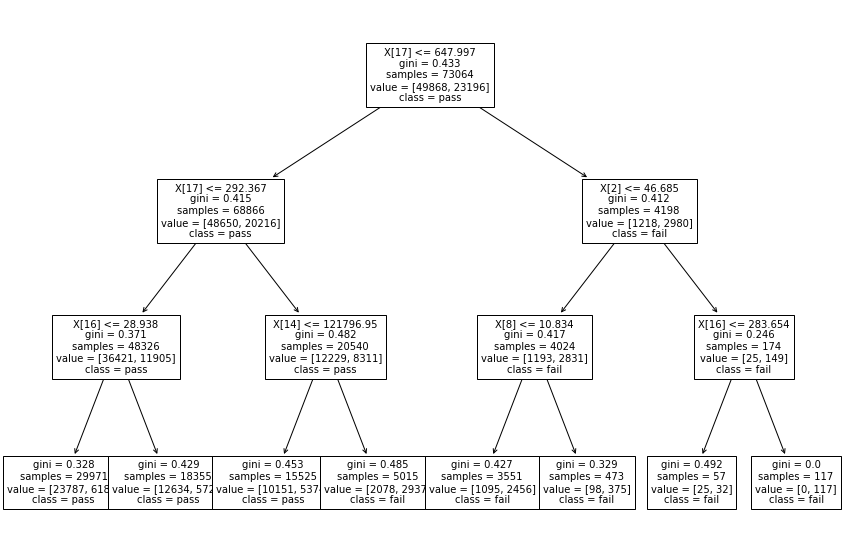

In [166]:
from sklearn import tree

# plot tree
plt.figure(figsize=(15,10))  # set plot size (denoted in inches)
tree.plot_tree(dt, fontsize=10, class_names=['pass','fail'])
plt.show()

#### Methods

In [134]:
print(dt.tree_.node_count)    # nbr nodes
print(dt.tree_.feature)       # list of features, one feature for each node
print(dt.tree_.threshold)     # All the thresholds

dt.tree_.threshold[3] = 10.0  # Manually modifying a threshold   

15
[17 17 16 -2 -2 14 -2 -2  2  8 -2 -2 16 -2 -2]
[ 6.47996955e+02  2.92367340e+02  2.89375357e+01 -2.00000000e+00
 -2.00000000e+00  1.21796950e+05 -2.00000000e+00 -2.00000000e+00
  4.66845316e+01  1.08344524e+01 -2.00000000e+00 -2.00000000e+00
  2.83653849e+02 -2.00000000e+00 -2.00000000e+00]


In [155]:
clf.tree_.children_left[0] # children_left[i]: id of the left child of node i or -1 if leaf node
# DFS traversal 

1

children_left[i]: id of the left child of node i or -1 if leaf node

children_right[i]: id of the right child of node i or -1 if leaf node

feature[i]: feature used for splitting node i

threshold[i]: threshold value at node i

n_node_samples[i]: the number of of training samples reaching node i

impurity[i]: the impurity at node 

In [47]:
clf = dt
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
feature_name = [list(df.columns)[i] for i in feature]
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[i, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature_name[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 15 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[i, gh_sloc] <= 436.0552215576172 else to node 8.
	node=1 is a split node: go to node 2 if X[i, gh_diff_other_files] <= 57233.5 else to node 5.
		node=2 is a split node: go to node 3 if X[i, gh_test_cases_per_kloc] <= 11.375139236450195 else to node 4.
			node=3 is a leaf node.
			node=4 is a leaf node.
		node=5 is a split node: go to node 6 if X[i, gh_test_lines_per_kloc] <= 29.131779670715332 else to node 7.
			node=6 is a leaf node.
			node=7 is a leaf node.
	node=8 is a split node: go to node 9 if X[i, gh_test_cases_per_kloc] <= 547.5184326171875 else to node 12.
		node=9 is a split node: go to node 10 if X[i, gh_test_cases_per_kloc] <= 529.2339172363281 else to node 11.
			node=10 is a leaf node.
			node=11 is a leaf node.
		node=12 is a split node: go to node 13 if X[i, gh_sloc] <= 3112.927001953125 else to node 14.
			node=13 is a leaf node.
			node=14 is a leaf

In [61]:
for name, importance in zip(feature_name, dt.feature_importances_):
    print(name, importance)

gh_sloc 0.0
gh_diff_other_files 0.0
gh_test_cases_per_kloc 0.0
tr_build_id 0.0
tr_build_id 0.0
gh_test_lines_per_kloc 0.0
tr_build_id 0.0
tr_build_id 0.0
gh_test_cases_per_kloc 0.0
gh_test_cases_per_kloc 0.0
tr_build_id 0.0
tr_build_id 0.0
gh_sloc 0.0
tr_build_id 0.0
tr_build_id 0.061644398669160785


In [111]:
from sklearn.metrics import f1_score 
f1_score(dt.predict(X_val),y_val)

0.26666666666666666

In [114]:
for i in range(dt.tree_.node_count):
    dt.tree_.threshold[i] = 0.0  # Manually modifying a threshold   
f1_score(dt.predict(X_val),y_val)

0.4819447330147517